##### Copyright 2023 The TensorFlow Authors.


In [65]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Latent Dirichlet Allocation - Sampling with Hamiltonian Markov-Chain-Monte-Carlo (HMC) Methods

_Notebook orignially contributed by: [Jannis Zeller](https://janniszeller.github.io/)_

This notebook shows how to implement inference for [Latent Dirichlet Allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) (LDA, sometimes also called "topic model"), a generative probabilistic model by Blei, Ng & Jordan (2003), with TensorFlow Probability's (`tfp`) HMC methods. For this presentation I use the popular toy model from [Griffiths & Steyvers (2004)](https://www.pnas.org/doi/full/10.1073/pnas.0307752101).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/probability/LDA-tfp-HMC.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/tensorflow_examples/probability/LDA-tfp-HMC.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

The LDA - joint distribution consists of:

1. Topic-Token prevalences (how much a topic "likes" a word): 
$$
    \Theta \sim \textsf{Dirichlet}(\beta) \qquad \Rightarrow \qquad \Theta \in \mathbb R^{K\times V}\ \ \textsf{such that} \ \ \sum_{v=1}^V \Theta_{kv} = 1\ \forall \ k\in \{1, \dots K\}\, .
$$

2. Document-Topic prevalences (how much a document "likes" a topic):
$$
    \Pi \sim \textsf{Dirichlet}(\alpha)  \qquad \Rightarrow \qquad \Pi     \in \mathbb R^{D\times K}\ \ \textsf{such that} \ \ \sum_{k=1}^K \Pi_{dk}    = 1\ \forall \ d\in \{1, \dots D\}\, .
$$

3. Topic-word assignments in each document (iid for all $N$ words in a document):
$$
    C \vert \Pi \sim \textsf{Categorical}(\Pi) \qquad \Rightarrow \qquad C \in \mathbb N^{D\times N}
$$ 

4. Actual words in a document: $$P(w_{di}=v \vert c_{dik}, \Theta) = \prod_k \Theta_{kv}^{c_{dik}},$$ where $c_{dik}$ is one-hot encoded. This is equivalend to $$W \vert C, \Theta \sim \textsf{Categorical}(\texttt{tf.gather(} \Theta, C \texttt{)} )\, .$$

Together this can be used to set up the joint: 
$$
    P(W, \Theta, \Pi, C) = P(W\vert C, \Theta)\cdot P(C\vert \Pi)\cdot P(\Pi)\cdot P(\Theta)\, . 
$$
For inference the actual words $W$ are given and we are interested in the posterior $P(\Theta, \Pi, C \vert W)$. This notebook presents how to approximate this distribution using [HMC](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) methods that are built in `tfp`.

## Setup

In [66]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

I have put together some source files that provide data-generation and plot utilities.

In [67]:
import src_lda.utils as tpc_utils
import src_lda.data  as tpc_data

---

## Data Generation

In this part the data is sampled. I have setup a sampler in one of the source files that transparently executes every step. This notebook shows how the procedure can be used with varying document lengths and with fixed document lengths.

In [68]:
N_docs       = 300
sqrt_N_vocab = 3
N_words      = 50

## Variable Document Lengths?
uniform_doclengths = False

N_topics = int(2*sqrt_N_vocab)
N_vocab  = int(sqrt_N_vocab**2)

Sampling a dataset with fixed document length or with varying document lengths

In [69]:
data = tpc_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words=N_words,
    uniform_doclengths=uniform_doclengths)

The choice of names for the tensors follows the Overview-section.

In [70]:
Theta, Pi, C_DId, C_DIdK, words = data.extract_params()

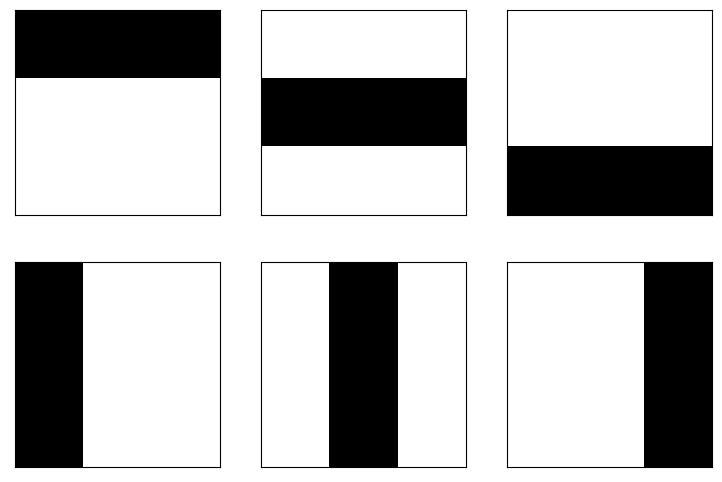

In [71]:
_ = tpc_utils.visualize_topics(Theta, N_row=2, N_col=3)

The goal is to reconstruct these topic-word prevalences using just the observed data, i. e. the `words`.

#### Preprocessing the Data

If the document length is variable, `tfp` methods are not directly applicable, because it lacks capabilities for processing `tf.RaggedTensor`s (as far as I can tell, 2023-01-31). Thus no (joint)-distribution can be defined which samples variable-length documents. The idea is, to pad each document to the size of the longest document base on the observed frequency of each token in the document in a catrgorical-distributed manner:

$$
    X_{\textsf{pad}}^{(j)} \overset{\textsf{iid}}{\sim} \textsf{Categorcial}\left( \frac{\textsf{count}(x_i)}{\textsf{len}(\textsf{doc}_j)}; \ i =1,\dots, V \right)
$$

This should work becaus topic models are bag-of-words models where only the (relative) frequency of token occurances matter. This approach will improve in performace the more word per document are used.

In [72]:
if not uniform_doclengths:
    pad_token = N_vocab + 1
    single_doclengths = words.nested_row_lengths()[0].numpy()
    N_words = tf.reduce_max(single_doclengths)

    words_ragged = words.to_tensor(N_vocab+1).numpy()
    words = []

    def pad_single_doc(doc, length, N_words_max=N_words):
        pad_size    = N_words_max - length
        doc_padded  = doc
        doc         = doc[doc != pad_token]
        idx, freq   = np.unique(doc, return_counts=True)
        freq        = freq / np.sum(freq)
        pad         = np.random.choice(idx, size=pad_size, p=freq)
        doc_padded[doc_padded == pad_token] = pad
        return doc_padded

    for doc, length in zip(words_ragged, single_doclengths):
        words.append(pad_single_doc(doc, length))
    
    words = tf.constant(words, dtype=tf.int32)

---

## Defining the Joint

Orientation was provided by https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability. Let $V$ be the size of the vocabulary, $D$ be the number of documents, $N$ be the (maximum) document size and $K$ be the number of topics. In this toy model which provides practical visualization capabilities we have $\sqrt{V} \in \mathbb N$ and $K=2 \cdot \sqrt{V} \in \mathbb N$.

The "$C$-step" can be "integrated out" using `tfp`'s `MixtureSameFamily`-distribution-class (see for gaussian mixture model in https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model).

In [73]:
## Priors:
alphas = tf.ones((N_docs, N_topics),  dtype=tf.float32)
betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)      
## Joint
joint = tfd.JointDistributionNamed(
    dict(
        Pi    = tfd.Dirichlet(alphas),
        Theta = tfd.Dirichlet(betas),
        W     = lambda Pi, Theta: tfd.Sample(  
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=Pi),
                components_distribution=tfd.Categorical(probs=Theta)),
            sample_shape=N_words)),
    batch_ndims=0,
    use_vectorized_map=True)

Testing the Joint

In [74]:
## Sampling behavior 
sample = joint.sample()
for key, val in sample.items():
    print(f"Joint Sample Shape {key}: {val.shape}")
## Log-probability of observed (possibly padded data) assuming the joint
p = joint.log_prob(W=words, Pi=Pi, Theta=Theta).numpy()
p_sample = joint.log_prob(
    W=sample['W'], Pi=sample['Pi'], Theta=sample['Theta']).numpy()
print(f"Log-Probability of the observed data (data generation above): {p}")
print(f"Log-Probability of the sample from the joint: {p_sample}")

Joint Sample Shape Theta: (6, 9)
Joint Sample Shape Pi: (300, 6)
Joint Sample Shape W: (300, 74)
Log-Probability of the observed data (data generation above): -43816.58203125
Log-Probability of the sample from the joint: -45987.359375


Presenting documents [147 180 290 132  76 118   4  67 254  92]


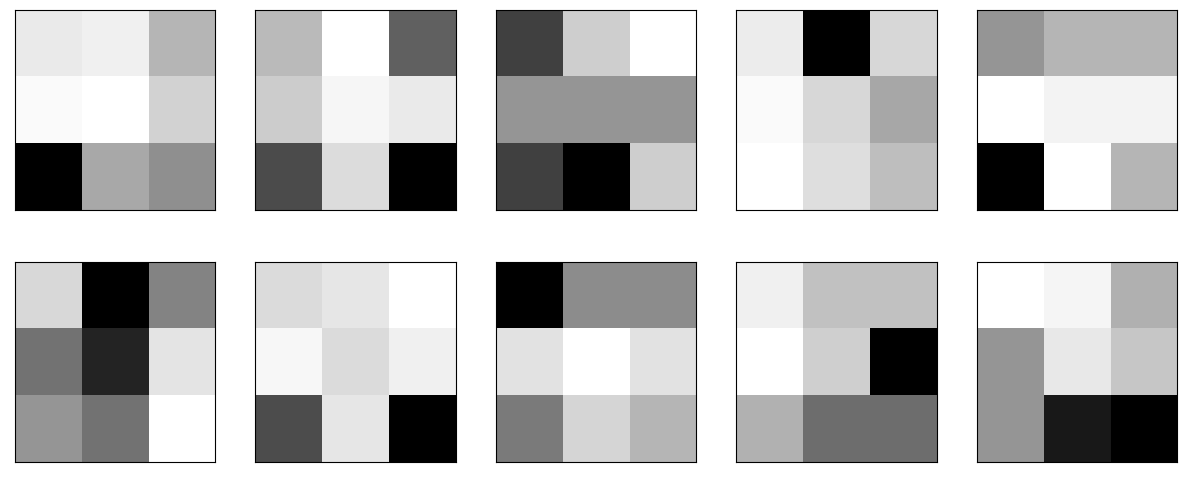

In [75]:
## Visualize documents from the prior-joint
_ = tpc_utils.visualize_random_docs(words, sqrt_V=sqrt_N_vocab)

### Defining the Unnormalized Posterior by Introducing the Data:

In [76]:
def unnormalized_posterior(Pi, Theta):
    return joint.log_prob(W=words, Pi=Pi, Theta=Theta) # Incorporate data with "words"

---

## HMC-Chain

Orientation was provided here: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo.

In [77]:
tf.config.experimental.enable_tensor_float_32_execution(False)

In [78]:
## Constraining the Dirichlet-Samples to discrete probability vectors
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.SoftmaxCentered()]

In [79]:
# Create an HMC TransitionKernel
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior,
            step_size=0.065,
            num_leapfrog_steps=5),
    bijector=unconstraining_bijectors),
    num_adaptation_steps=400)

In [80]:
# We wrap sample_chain in tf.function
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=1000):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

In [81]:
init_pis    = tf.ones_like(Pi, dtype=tf.float32)
init_thetas = tf.ones_like(Theta, dtype=tf.float32)
initial_state = [init_pis, init_thetas]

samples, is_accepted = run_chain(initial_state)

In [82]:
print("Acceptance rate:", 
    tf.reduce_sum(
        tf.cast(is_accepted, dtype=tf.int16)/is_accepted.shape[0]
    ).numpy()
)

Acceptance rate: 0.547


In [83]:
Pi_fit    = tf.reduce_mean(samples[0], axis=0)
Theta_fit = tf.reduce_mean(samples[1], axis=0)

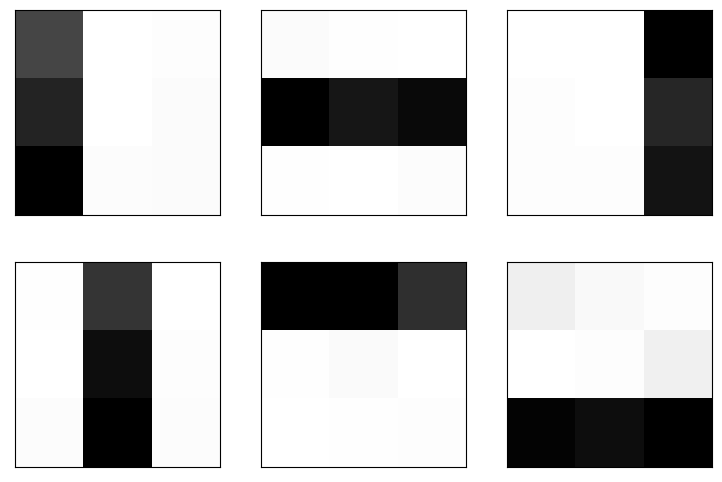

In [84]:
_ = tpc_utils.visualize_topics(Theta_fit, N_row=2, N_col=3)

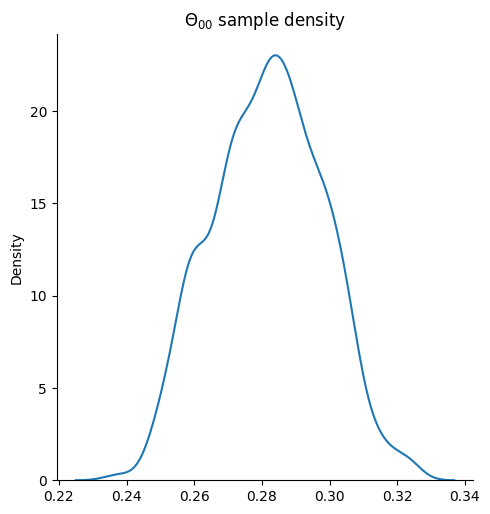

In [85]:
Theta_00 = samples[1][:, 0, 0].numpy()
_ = sns.displot(
    Theta_00, 
    kind="kde").set(
    title="$\Theta_{00}$ sample density")

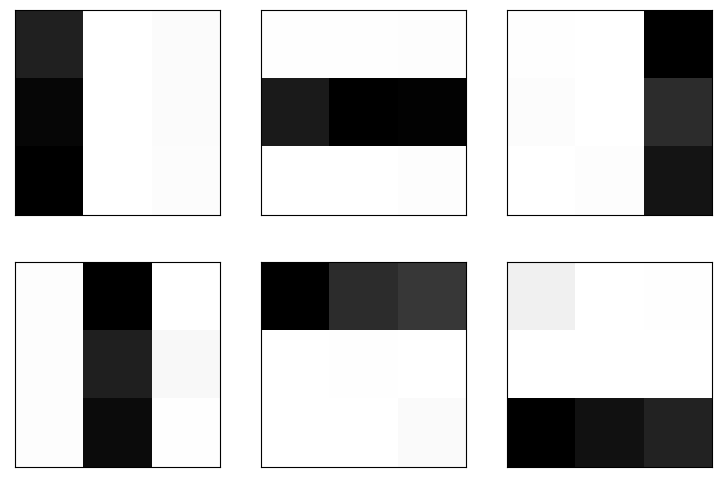

In [86]:
## Is is also possible to train on after initial training by setting the initial
#  state:
initial_state = [Pi_fit, Theta_fit]
samples, is_accepted = run_chain(initial_state, num_results=1000, num_burnin_steps=500)

Pi_fit    = tf.reduce_mean(samples[0], axis=0)
Theta_fit = tf.reduce_mean(samples[1], axis=0)
_ = tpc_utils.visualize_topics(samples[1][-1, :], N_row=2, N_col=3)

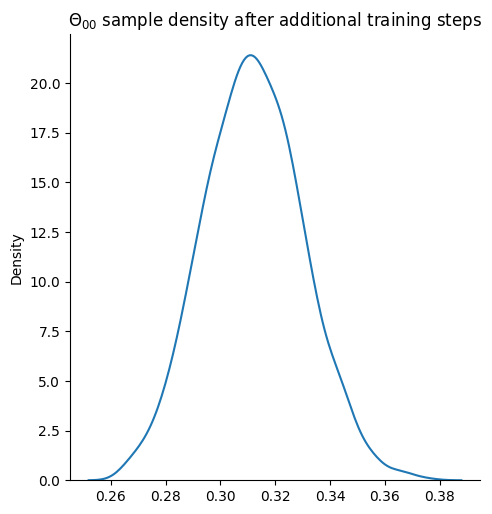

In [87]:
Theta_00 = samples[1][:, 0, 0].numpy()
_ = sns.displot(
    Theta_00, 
    kind="kde").set(
    title="$\Theta_{00}$ sample density after additional training steps")

---

Thank you for following this notebook until here. I invite you to also have a look at [my repo](https://github.com/JannisZeller/topicflow) where I show a slightly more comprehensive version of this notebook as well as a custom Gibbs-Sampling method, that is just based on linear algebra operations and can also process data in batches.